# DDE model with gradients

DDEs require models that produces output beased on its gradients wrt. to the input. So we make our own model that transfers the output of a neural network by computing its gradients.

In [2]:
# This is the implementation of the Energy-based Genertive Models, which uses DDEs to compute the KL-divergence loss's gradients
from tensorflow import keras

# We use DDEs for density estimation
# the EGMs can use any type of density (energy)-based models, even unnormalized estimators
from energy_models import DDE

class EGM(keras.Model):
    def __init__(self, dde_real, dde_fake, gen, noise_std, batch_size, dde_inner_loop=5):
        super(EGM, self).__init__()
        self.dde_real = DDE(dde_real)
        self.dde_fake = DDE(dde_fake)
        self.gen = gen
        self.noise_std = noise_std
        self.batch_size = batch_size
        self.dde_inner_loop = dde_inner_loop

    def compile(self, dde_optimizer, gen_optimizer):
        super(EGM, self).compile()
        self.gen_optimizer = gen_optimizer
        self.dde_optimizer = dde_optimizer
        self.dde_real.compile(dde_optimizer)
        self.dde_fake.compile(dde_optimizer)

    def get_batch_noise(self):
        return tf.random.normal(shape=(self.batch_size,gen_noise_dims), mean=0.0, stddev=1, dtype=tf.float32)
    
    # Replace the call function of the model to include the gradient computation
    def call(self, batch_noise, ignore_input=True):
        if ignore_input:
            batch_noise = self.get_batch_noise()
            
        fake_images = self.gen(batch_noise, training=True)
        return fake_images

    def gaussian_noise_layer(self, input_layer):
        noise = tf.random.normal(shape=tf.shape(input_layer), mean=0.0, stddev=self.noise_std, dtype=tf.float32) 
        return input_layer + noise, -noise/self.noise_std/self.noise_std

    # Calculate the noise estimation penalty based on reverse KL-divergence
    def kl_penalty(self, fake):
        """ Calculates the reverse KL loss.
        """
        
        n_fake = self.gaussian_noise_layer(fake)
        
        log_prob1_fake, _ = self.dde_real(n_fake)
        log_prob2_fake, _ = self.dde_fake(n_fake)
        
        # 3. Calcuate the loss
        loss = tf.reduce_sum(log_prob2_fake - log_prob1_fake)
        
        return loss
    
    def dde_steps(self, real, fake):
        """ Takes a step to optimize DDEs.
        """
        noisy_real, noise_gt_real = self.gaussian_noise_layer(real)
        noisy_fake, noise_gt_fake = self.gaussian_noise_layer(fake)

        l1 = self.dde_real.train_step([noisy_real, noise_gt_real])
        l2 = self.dde_fake.train_step([noisy_fake, noise_gt_fake])
        
        return l1["loss"], l2["loss"]
    
    # Calculate model gradients for optimization and take an optimization step(s).
    def train_step(self, input):
        real_images = input
        
        # Take a step to optimize the generator
        with tf.GradientTape() as tape:
            fake_images = self.call(0)
            loss = self.kl_penalty(fake_images)

            # Get the gradients w.r.t the generator loss
            gradient = tape.gradient(loss, self.gen.trainable_variables)
            # Update the weights of the generator using the generator optimizer
            self.gen_optimizer.apply_gradients(zip(gradient, self.gen.trainable_variables))

        # Take steps to optimize the DDEs
        dde_variables = self.dde_real.trainable_variables+self.dde_fake.trainable_variables
        for i in range(self.dde_inner_loop):
            with tf.GradientTape() as tape:
                l1, l2 = self.dde_steps(real_images, fake_images)

        return {"loss_dde_real": l1, "loss_dde_fake": l2, "gen_loss": loss}


In [3]:
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

kernel_initializer = 'he_normal'
data_size = (2,)
gen_noise_dims = 2

def generate_dde_net_model(pretrained_weights = None, input_size=data_size, ch=32):
    inputs = Input(input_size)
    inputs2 = Flatten()(inputs)
    layer = Dense(32*ch, activation='tanh', kernel_initializer=kernel_initializer)(inputs2)
    layer = Dense(16*ch, activation='tanh', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(8*ch, activation='tanh', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(4*ch, activation='tanh', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(2*ch, activation='tanh', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(ch, activation='tanh', kernel_initializer=kernel_initializer)(layer)
    log_prob = Dense(10, activation='linear', use_bias=False, kernel_initializer=kernel_initializer)(layer)
    model = Model(inputs, log_prob)
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

kernel_initializer = 'glorot_normal'

def generate_gen_net_model(pretrained_weights = None, input_size=(gen_noise_dims), output_size=data_size, ch=32):
    inputs = Input(input_size)
    layer = Dense(ch, activation='relu', kernel_initializer=kernel_initializer)(inputs)
    layer = Dense(2*ch, activation='relu', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(4*ch, activation='relu', kernel_initializer=kernel_initializer)(layer)
    layer = Dense(8*ch, activation='relu', kernel_initializer=kernel_initializer)(layer)
    #layer = Dense(16*ch, activation='relu', kernel_initializer=kernel_initializer)(layer)
    #layer = Dense(32*ch, activation='relu', kernel_initializer=kernel_initializer)(layer)
    output = Dense(np.prod(output_size), activation='linear', use_bias=False, kernel_initializer=kernel_initializer)(layer)
    output_shape = (-1,)
    for i in output_size:
        output_shape += (i,)
    output2 = tf.reshape(output, output_shape)
    model = Model(inputs, output2)
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
# Select GPUs and generate the network model
import tensorflow as tf

gpu_to_restrict = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_to_restrict], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_to_restrict], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
        
net_dde1 = generate_dde_net_model(pretrained_weights = None)
net_dde2 = generate_dde_net_model(pretrained_weights = None)
net_gen = generate_gen_net_model(pretrained_weights = None)

1 Physical GPUs, 1 Logical GPU
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3072      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)        

In [5]:
# Creat our EGM model and pass it the neural networks and their optimizers

batch_size = 2048
dde_noise_std = 0.1 # a hyperparameter indicating the KDE std. To be set relative to the distance between data samples

egm = EGM(net_dde1, net_dde2, net_gen, noise_std=dde_noise_std, batch_size=batch_size)
dde_optimizer = tf.optimizers.Adam(lr = 1e-3)
gen_optimizer = tf.optimizers.Adam(lr = 1e-5)
egm.compile(dde_optimizer=dde_optimizer, gen_optimizer=gen_optimizer)#, loss = ['mse', None], metrics = ['mse', None])


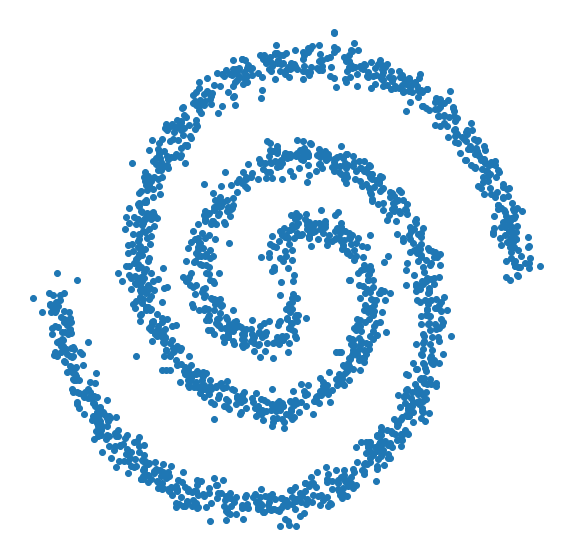

In [6]:
# Data generator implementation for 2D toy distributions: 8gaussians, 2spirals, checkerboard, rings

from tensorflow.keras.utils import Sequence
from utils import sample_2d_data
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, num_total_samples=1e4, dataset='2spirals', batch_size=512):
        'Initialization'
        self.batch_size = batch_size
        self.num_total_samples = num_total_samples
        self.data = sample_2d_data(dataset, int(self.num_total_samples))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.num_total_samples // self.batch_size)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise ValueError("idx must be an integer.")
        if not 0 <= idx < self.__len__():
            raise ValueError("idx is out of bounds.")

        # extract the current batch from dataset
        batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
               
        # output the ground truth samples from the dataset
        return batch

# This is a helper function to generate the denoised results from noisy input and noise estimates
def get_denoised(input_noisy, noise_estimate, sigma):
    return input_noisy+noise_estimate*sigma*sigma


# Visualise some samples
import matplotlib.pyplot as plt
generator = DataGenerator(batch_size=batch_size)
batch_gt = generator.__getitem__(0)
plt.figure(figsize=(10,10))
plt.plot(batch_gt[:,0], batch_gt[:,1], 'o')
#plt.plot(batch_noisy[:,0], batch_noisy[:,1], '.r')
_=plt.axis("off")


In [7]:
# Helper functions for visualization of the generated samples and density

visualization_batch_noise = egm.get_batch_noise()

def show_sampling_plot():
    batch_gt = generator.__getitem__(0)
    batch_fake = egm.call(visualization_batch_noise, ignore_input=False).numpy()

    plt.figure(figsize=(10,10))
    plt.plot(batch_gt[:,0], batch_gt[:,1], 'o')
    plt.plot(batch_fake[:,0], batch_fake[:,1], '.r')
    plt.axis("off")


def get_density_map(dde, wdt = 4, granularity = 10):
    x_range = np.array(range(-wdt*granularity, wdt*granularity))/granularity
    y_range = np.array(range(wdt*granularity, -wdt*granularity, -1))/granularity
    
    X, Y = np.meshgrid(x_range, y_range)
    shape = X.shape
    X = X.reshape(np.prod(shape), order='C')
    Y = Y.reshape(np.prod(shape), order='C')
    input_data = np.array([X,Y]).transpose()

    log_prob_data = dde(input_data)[0].numpy()
    log_prob_data -= log_prob_data.max()
    prob_data = np.exp(log_prob_data[:,0])
    prob_data = prob_data.reshape(shape, order='C')
    return prob_data


def show_density_plot(prob_data):        
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(prob_data)
    ax.set_axis_off()

In [8]:
# Helper functions and callbacks for visualization and writing of the results

from tensorflow import keras
import matplotlib.pyplot as plt
class ImagePlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 != 0:
            return
        
        show_sampling_plot()
        plt.show()
        

class DensityPlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 != 0:
            return
        
        logp = get_density_map(egm.dde_real)
        show_density_plot(logp)
        logp = get_density_map(egm.dde_fake)
        show_density_plot(logp)
        plt.show()
        

save_folder = '2spirals_gen/'
class DensityPlotWriterCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 10000 and epoch%1000 != 0:
            return
        if 300< epoch < 10000 and epoch%100 != 0:
            return
        epoch_id = str(epoch).zfill(6)
        
        plt.ion()
        
        logp = get_density_map(egm.dde_real)
        show_density_plot(logp)
        plt.savefig(save_folder+'den_real_' + epoch_id)
        plt.close(plt.gcf())
        
        logp = get_density_map(egm.dde_fake)
        show_density_plot(logp)
        plt.savefig(save_folder+'den_fake_' + epoch_id)
        plt.close(plt.gcf())
        
        show_sampling_plot()
        plt.savefig(save_folder+'samples_' + epoch_id)
        plt.close(plt.gcf())
        plt.ioff()
        

Epoch 1/1000
3/4 [=====================>........] - ETA: 0s - loss_dde_real: 98.2070 - loss_dde_fake: 90.7150 - gen_loss: 200.4840

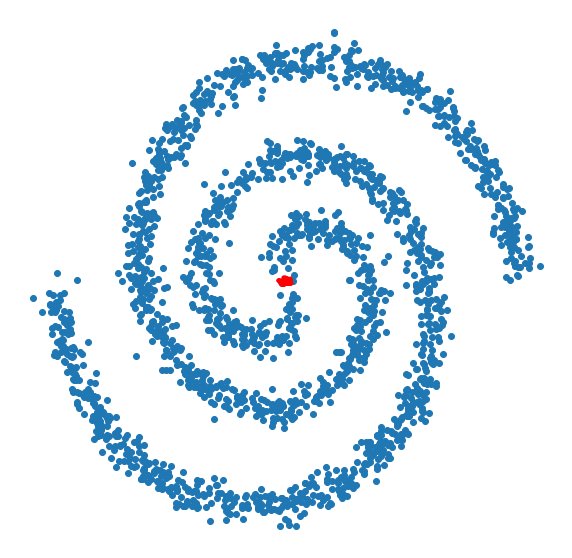


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



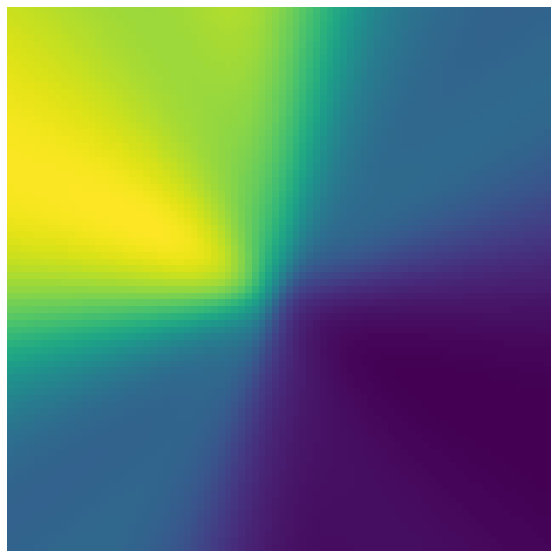

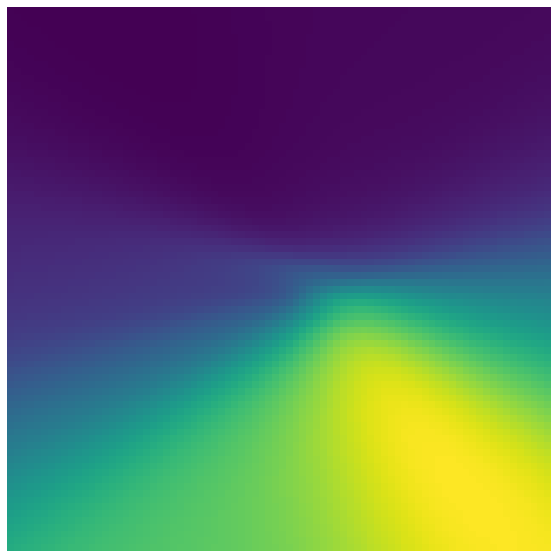

4/4 [==============================] - 0s 76ms/step - loss_dde_real: 98.1076 - loss_dde_fake: 77.2759 - gen_loss: 1172.5156
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss_dde_real: 98.4923 - loss_dde_fake: 13.4745 - gen_loss: 9012.2121
Epoch 3/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 102.3803 - loss_dde_fake: 4.8638 - gen_loss: 17775.9598
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 100.4921 - loss_dde_fake: 4.0217 - gen_loss: 21378.2883
Epoch 5/1000
4/4 [==============================] - 0s 25ms/step - loss_dde_real: 99.8928 - loss_dde_fake: 3.7898 - gen_loss: 22208.9043
Epoch 6/1000
4/4 [==============================] - 0s 25ms/step - loss_dde_real: 99.4037 - loss_dde_fake: 3.7505 - gen_loss: 22299.4855
Epoch 7/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 98.1451 - loss_dde_fake: 3.7841 - gen_loss: 22677.8070
Epoch 8/1000
4/4 [==============================] - 

4/4 [==============================] - 0s 23ms/step - loss_dde_real: 80.1639 - loss_dde_fake: 36.4012 - gen_loss: 15276.5498
Epoch 61/1000
4/4 [==============================] - 0s 27ms/step - loss_dde_real: 78.9754 - loss_dde_fake: 36.7214 - gen_loss: 14994.2742
Epoch 62/1000
4/4 [==============================] - 0s 22ms/step - loss_dde_real: 79.7485 - loss_dde_fake: 37.9709 - gen_loss: 14895.1984
Epoch 63/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 78.4125 - loss_dde_fake: 38.7083 - gen_loss: 15402.7971
Epoch 64/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 80.2574 - loss_dde_fake: 39.1758 - gen_loss: 14686.1725
Epoch 65/1000
4/4 [==============================] - 0s 22ms/step - loss_dde_real: 79.2809 - loss_dde_fake: 39.3584 - gen_loss: 14506.6434
Epoch 66/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 77.5478 - loss_dde_fake: 39.4096 - gen_loss: 13310.1863
Epoch 67/1000
4/4 [======================

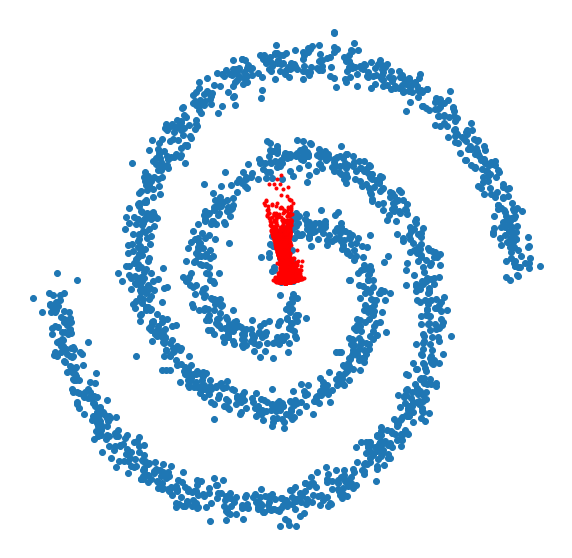

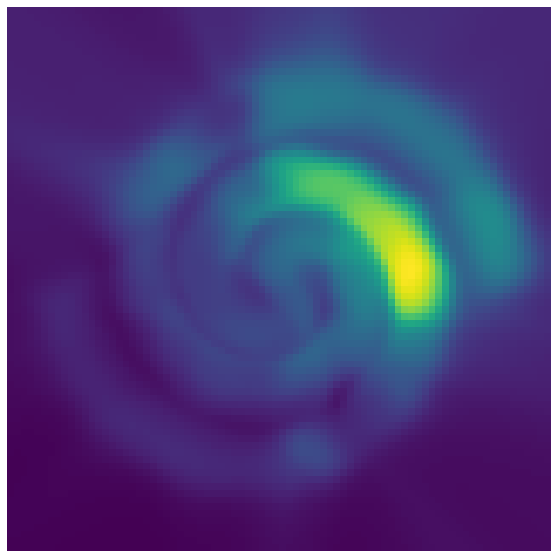

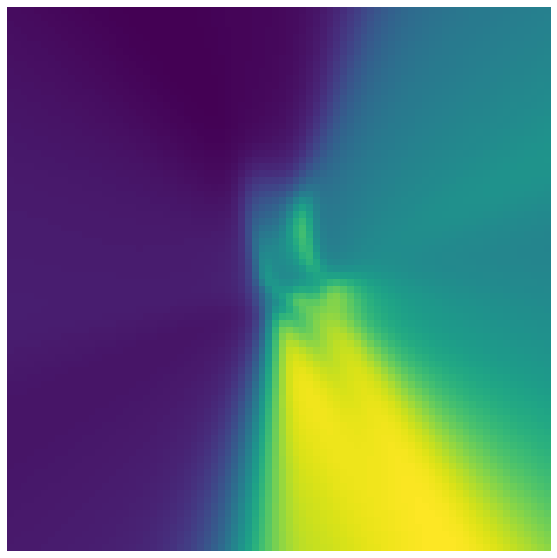

4/4 [==============================] - 0s 89ms/step - loss_dde_real: 78.7121 - loss_dde_fake: 50.2257 - gen_loss: 15335.6730
Epoch 102/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 80.6091 - loss_dde_fake: 51.2793 - gen_loss: 15248.3643
Epoch 103/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 80.8581 - loss_dde_fake: 51.1947 - gen_loss: 15843.3953
Epoch 104/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 78.7336 - loss_dde_fake: 51.1102 - gen_loss: 14751.2861
Epoch 105/1000
4/4 [==============================] - 0s 25ms/step - loss_dde_real: 80.2251 - loss_dde_fake: 51.8451 - gen_loss: 16595.8836
Epoch 106/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 79.2198 - loss_dde_fake: 54.0718 - gen_loss: 15953.0420
Epoch 107/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 78.8055 - loss_dde_fake: 51.8219 - gen_loss: 16865.6848
Epoch 108/1000
4/4 [===============

4/4 [==============================] - 0s 28ms/step - loss_dde_real: 79.4040 - loss_dde_fake: 64.3637 - gen_loss: 15375.8965
Epoch 160/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 77.8299 - loss_dde_fake: 64.8471 - gen_loss: 16611.5691
Epoch 161/1000
4/4 [==============================] - 0s 29ms/step - loss_dde_real: 79.4581 - loss_dde_fake: 64.0134 - gen_loss: 16907.3395
Epoch 162/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 80.9519 - loss_dde_fake: 62.3031 - gen_loss: 17695.5523
Epoch 163/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 77.9320 - loss_dde_fake: 64.7021 - gen_loss: 17481.0055
Epoch 164/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.9531 - loss_dde_fake: 65.5866 - gen_loss: 16726.1000
Epoch 165/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.7469 - loss_dde_fake: 65.9508 - gen_loss: 16525.9799
Epoch 166/1000
4/4 [===============

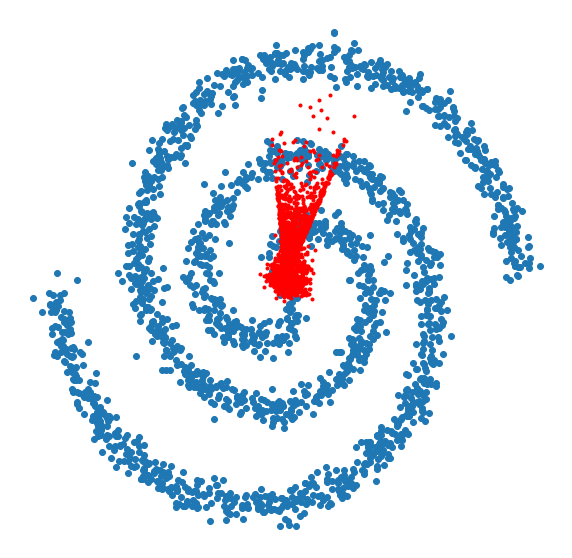

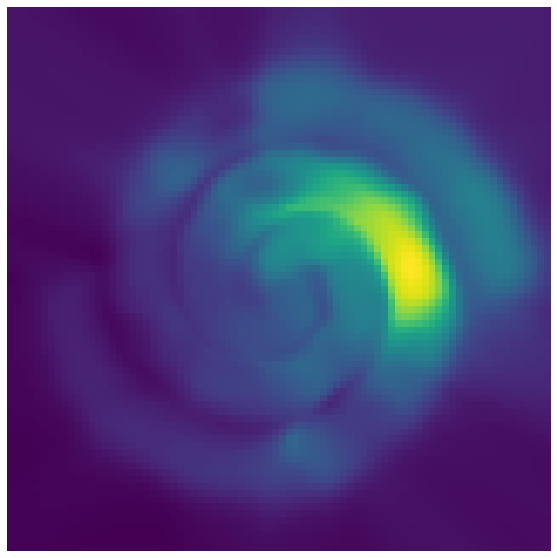

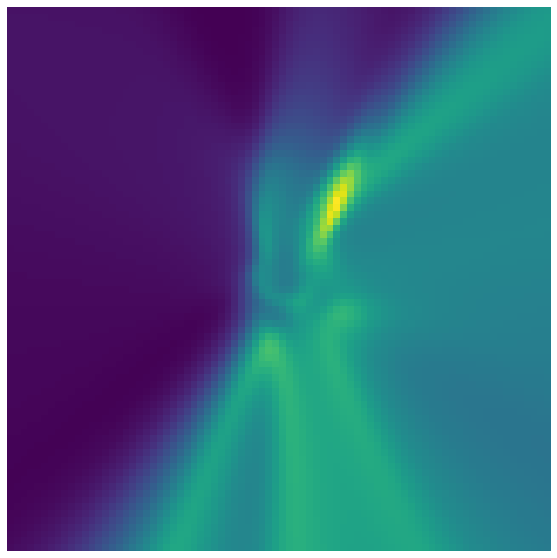

4/4 [==============================] - 0s 81ms/step - loss_dde_real: 79.6476 - loss_dde_fake: 71.9204 - gen_loss: 17776.2070
Epoch 202/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 78.9973 - loss_dde_fake: 71.2626 - gen_loss: 18063.6000
Epoch 203/1000
4/4 [==============================] - 0s 24ms/step - loss_dde_real: 78.7385 - loss_dde_fake: 71.8056 - gen_loss: 17585.4426
Epoch 204/1000
4/4 [==============================] - 0s 29ms/step - loss_dde_real: 78.4585 - loss_dde_fake: 70.2931 - gen_loss: 16523.6430
Epoch 205/1000
4/4 [==============================] - 0s 29ms/step - loss_dde_real: 78.4024 - loss_dde_fake: 73.3099 - gen_loss: 17445.1930
Epoch 206/1000
4/4 [==============================] - 0s 29ms/step - loss_dde_real: 78.1714 - loss_dde_fake: 72.5333 - gen_loss: 16427.8398
Epoch 207/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.6600 - loss_dde_fake: 72.5817 - gen_loss: 16825.5988
Epoch 208/1000
4/4 [===============

4/4 [==============================] - 0s 28ms/step - loss_dde_real: 78.5504 - loss_dde_fake: 76.4692 - gen_loss: 17969.3891
Epoch 260/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.9157 - loss_dde_fake: 77.4371 - gen_loss: 17703.3801
Epoch 261/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.9408 - loss_dde_fake: 77.0780 - gen_loss: 18517.6113
Epoch 262/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 77.6056 - loss_dde_fake: 78.2591 - gen_loss: 18744.6605
Epoch 263/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.6488 - loss_dde_fake: 79.9874 - gen_loss: 18942.0891
Epoch 264/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 77.2991 - loss_dde_fake: 78.2489 - gen_loss: 19784.2930
Epoch 265/1000
4/4 [==============================] - 0s 35ms/step - loss_dde_real: 78.2054 - loss_dde_fake: 78.1980 - gen_loss: 19862.4270
Epoch 266/1000
4/4 [===============

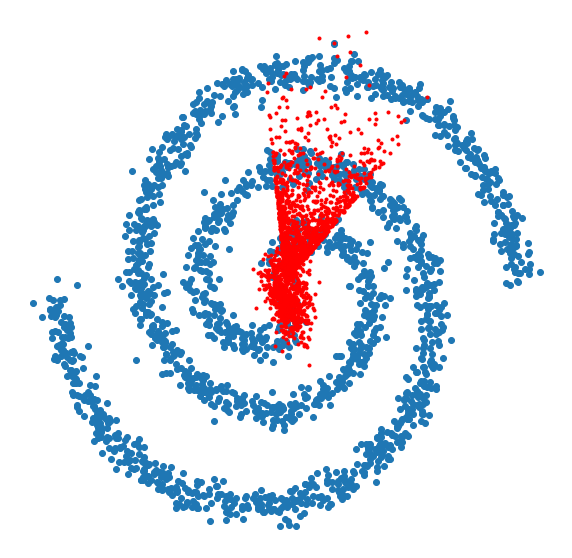

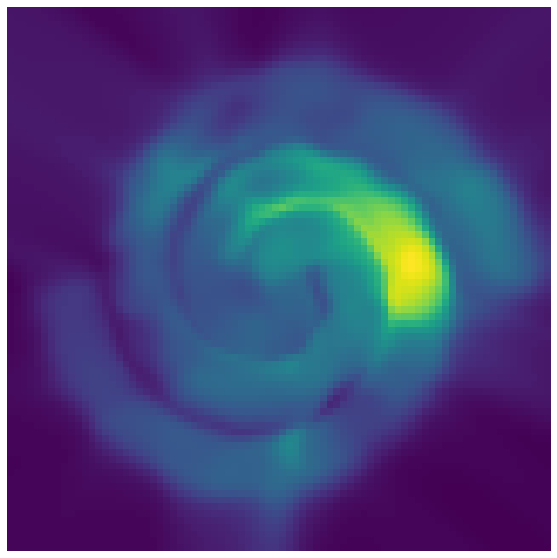

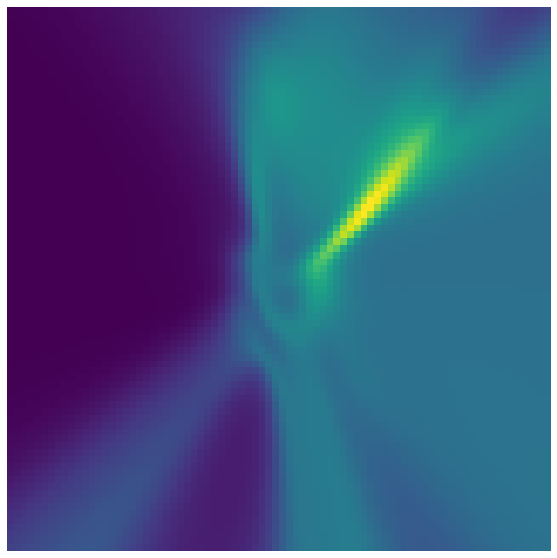

4/4 [==============================] - 0s 76ms/step - loss_dde_real: 79.2125 - loss_dde_fake: 82.0725 - gen_loss: 20340.4730
Epoch 302/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 78.0516 - loss_dde_fake: 80.8461 - gen_loss: 20342.6703
Epoch 303/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 79.9347 - loss_dde_fake: 81.7653 - gen_loss: 20084.4258
Epoch 304/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 77.4069 - loss_dde_fake: 79.6706 - gen_loss: 19800.6941
Epoch 305/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.0944 - loss_dde_fake: 82.7490 - gen_loss: 20860.1266
Epoch 306/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 78.6670 - loss_dde_fake: 79.6674 - gen_loss: 20091.2918
Epoch 307/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.7458 - loss_dde_fake: 81.5727 - gen_loss: 19324.4477
Epoch 308/1000
4/4 [===============

4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.4342 - loss_dde_fake: 84.2750 - gen_loss: 21475.1848
Epoch 360/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.6995 - loss_dde_fake: 83.0967 - gen_loss: 20671.2805
Epoch 361/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 79.2362 - loss_dde_fake: 82.8438 - gen_loss: 20634.7695
Epoch 362/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.6668 - loss_dde_fake: 82.4468 - gen_loss: 20226.8906
Epoch 363/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 79.2206 - loss_dde_fake: 83.6145 - gen_loss: 20503.8688
Epoch 364/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.8763 - loss_dde_fake: 84.4562 - gen_loss: 19676.3730
Epoch 365/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 78.0204 - loss_dde_fake: 82.8009 - gen_loss: 20124.8305
Epoch 366/1000
4/4 [===============

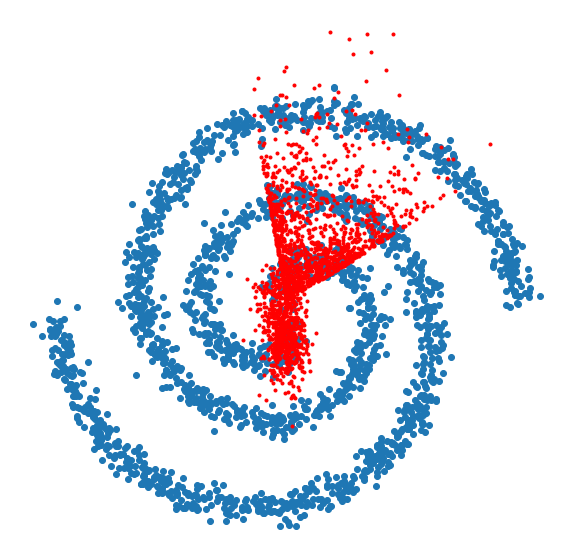

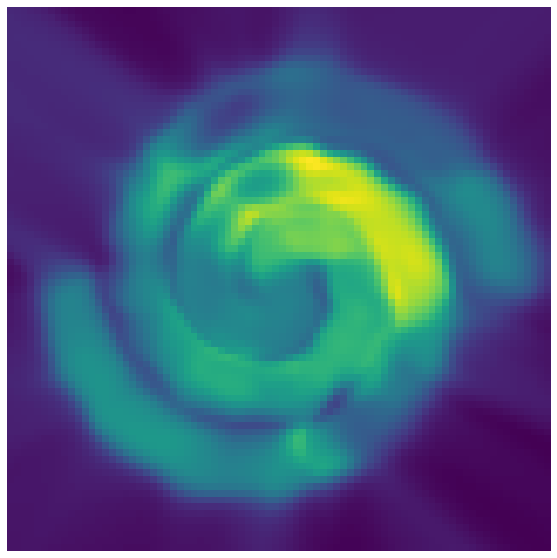

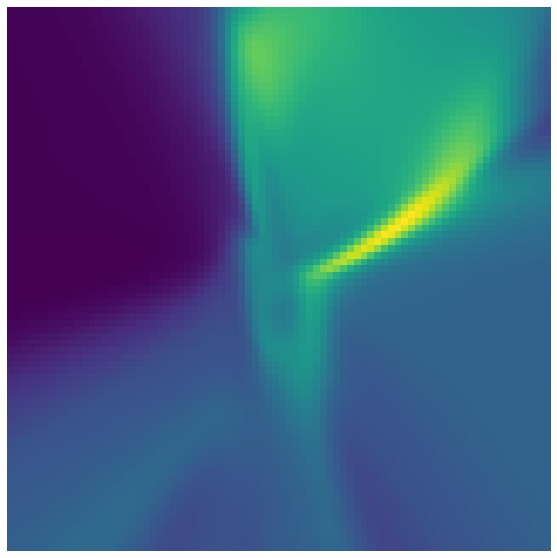

4/4 [==============================] - 0s 72ms/step - loss_dde_real: 79.3933 - loss_dde_fake: 85.1658 - gen_loss: 19854.4672
Epoch 402/1000
4/4 [==============================] - 0s 26ms/step - loss_dde_real: 78.9163 - loss_dde_fake: 83.4294 - gen_loss: 20055.8652
Epoch 403/1000
4/4 [==============================] - 0s 27ms/step - loss_dde_real: 76.9711 - loss_dde_fake: 83.3818 - gen_loss: 20591.9848
Epoch 404/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.3920 - loss_dde_fake: 86.7336 - gen_loss: 21091.3000
Epoch 405/1000
4/4 [==============================] - 0s 29ms/step - loss_dde_real: 78.0681 - loss_dde_fake: 86.3627 - gen_loss: 21538.1344
Epoch 406/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 77.6469 - loss_dde_fake: 85.7117 - gen_loss: 21895.7449
Epoch 407/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 79.6503 - loss_dde_fake: 84.9269 - gen_loss: 21117.5289
Epoch 408/1000
4/4 [===============

4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.5094 - loss_dde_fake: 88.0499 - gen_loss: 20359.3793
Epoch 460/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 77.3612 - loss_dde_fake: 87.6530 - gen_loss: 20927.5379
Epoch 461/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 76.3950 - loss_dde_fake: 85.9008 - gen_loss: 20525.8793
Epoch 462/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 79.0308 - loss_dde_fake: 87.6488 - gen_loss: 19812.5652
Epoch 463/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.7276 - loss_dde_fake: 88.0932 - gen_loss: 19990.6328
Epoch 464/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.6546 - loss_dde_fake: 85.2410 - gen_loss: 19988.5090
Epoch 465/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 80.5445 - loss_dde_fake: 87.0312 - gen_loss: 19306.5211
Epoch 466/1000
4/4 [===============

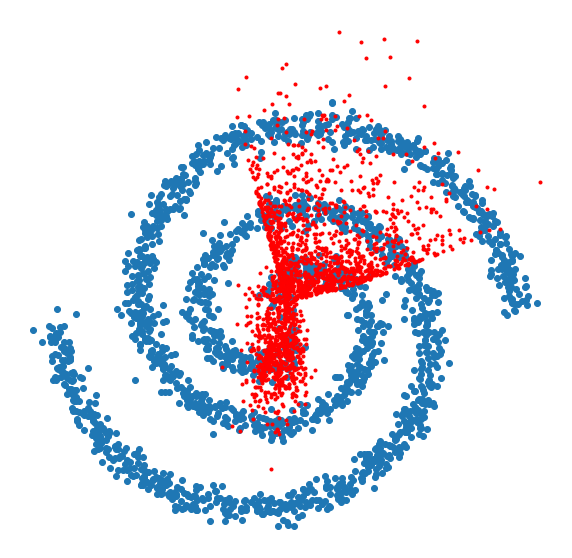

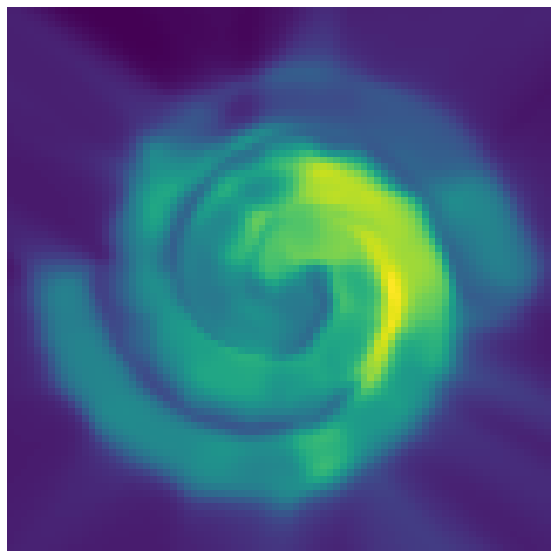

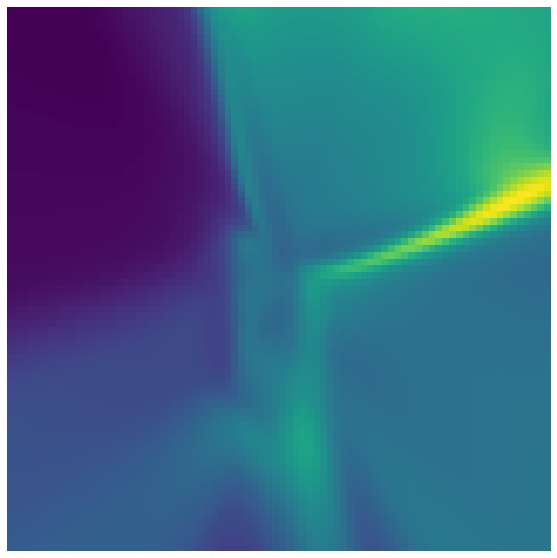

4/4 [==============================] - 0s 77ms/step - loss_dde_real: 81.2743 - loss_dde_fake: 87.3185 - gen_loss: 15201.8967
Epoch 502/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 75.8837 - loss_dde_fake: 88.0853 - gen_loss: 15748.1045
Epoch 503/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 78.8070 - loss_dde_fake: 90.4508 - gen_loss: 15140.2936
Epoch 504/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 78.0949 - loss_dde_fake: 90.0989 - gen_loss: 14205.3961
Epoch 505/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.7970 - loss_dde_fake: 87.7626 - gen_loss: 14103.7527
Epoch 506/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 80.9043 - loss_dde_fake: 87.9161 - gen_loss: 14824.2619
Epoch 507/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 79.0147 - loss_dde_fake: 86.6264 - gen_loss: 14273.8863
Epoch 508/1000
4/4 [===============

4/4 [==============================] - 0s 34ms/step - loss_dde_real: 77.3057 - loss_dde_fake: 87.3996 - gen_loss: 17006.0566
Epoch 560/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 77.6235 - loss_dde_fake: 89.2968 - gen_loss: 16985.4770
Epoch 561/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 77.3425 - loss_dde_fake: 87.3356 - gen_loss: 16716.8051
Epoch 562/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.4884 - loss_dde_fake: 89.4862 - gen_loss: 16946.3223
Epoch 563/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 79.1049 - loss_dde_fake: 89.2560 - gen_loss: 16536.0551
Epoch 564/1000
4/4 [==============================] - 0s 36ms/step - loss_dde_real: 78.2782 - loss_dde_fake: 86.8076 - gen_loss: 16726.8779
Epoch 565/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.4141 - loss_dde_fake: 90.0427 - gen_loss: 16282.2561
Epoch 566/1000
4/4 [===============

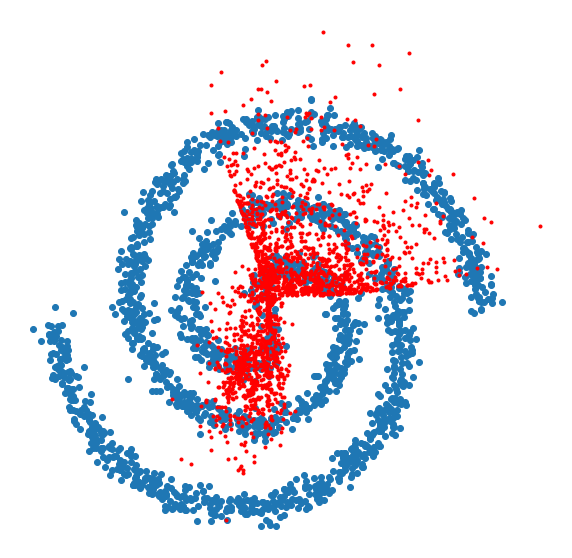

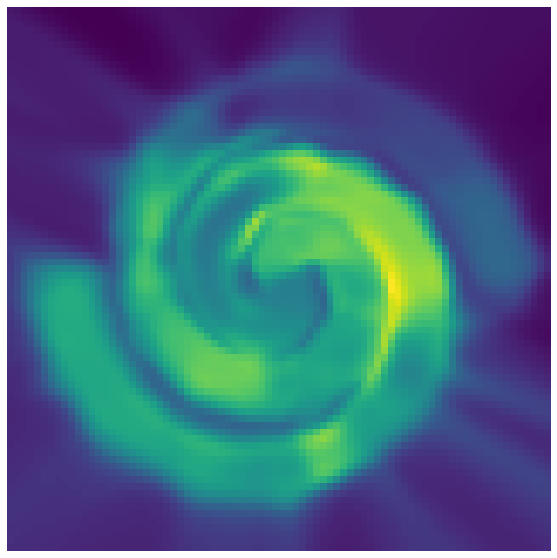

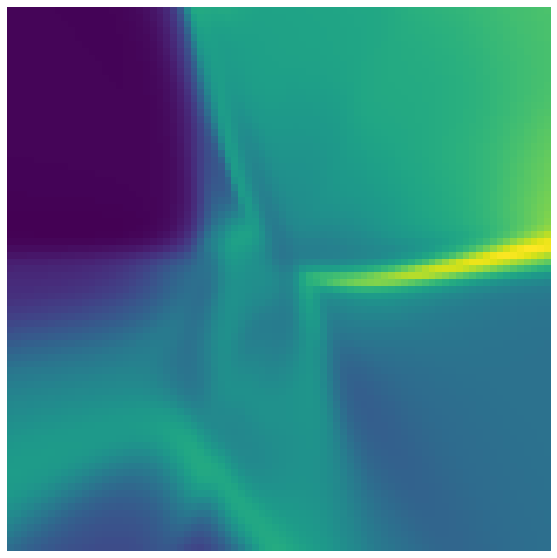

4/4 [==============================] - 0s 80ms/step - loss_dde_real: 77.9740 - loss_dde_fake: 90.8344 - gen_loss: 16611.8750
Epoch 602/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 77.9856 - loss_dde_fake: 89.2513 - gen_loss: 18368.7059
Epoch 603/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.1971 - loss_dde_fake: 92.1225 - gen_loss: 17841.2375
Epoch 604/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 79.0346 - loss_dde_fake: 87.6390 - gen_loss: 17076.4559
Epoch 605/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 79.7335 - loss_dde_fake: 89.8520 - gen_loss: 17599.8434
Epoch 606/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 79.5219 - loss_dde_fake: 91.0010 - gen_loss: 17623.8906
Epoch 607/1000
4/4 [==============================] - 0s 35ms/step - loss_dde_real: 78.4050 - loss_dde_fake: 92.7180 - gen_loss: 17670.4207
Epoch 608/1000
4/4 [===============

4/4 [==============================] - 0s 32ms/step - loss_dde_real: 77.8627 - loss_dde_fake: 91.0245 - gen_loss: 15707.0377
Epoch 660/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 77.9388 - loss_dde_fake: 90.8198 - gen_loss: 16026.3729
Epoch 661/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.5106 - loss_dde_fake: 89.9382 - gen_loss: 16223.1541
Epoch 662/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.2135 - loss_dde_fake: 90.9317 - gen_loss: 16511.4578
Epoch 663/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 79.4769 - loss_dde_fake: 88.8862 - gen_loss: 15813.4326
Epoch 664/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 80.1704 - loss_dde_fake: 90.6264 - gen_loss: 16663.1125
Epoch 665/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.9541 - loss_dde_fake: 91.4052 - gen_loss: 16811.5617
Epoch 666/1000
4/4 [===============

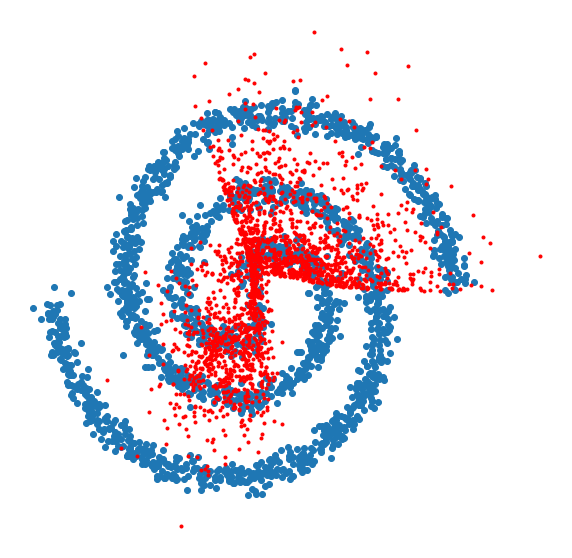

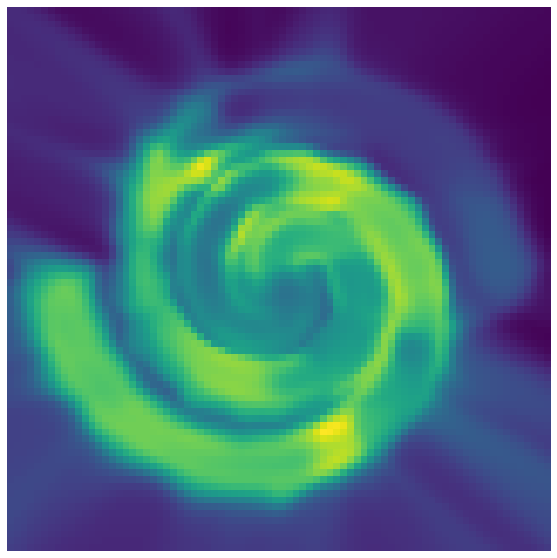

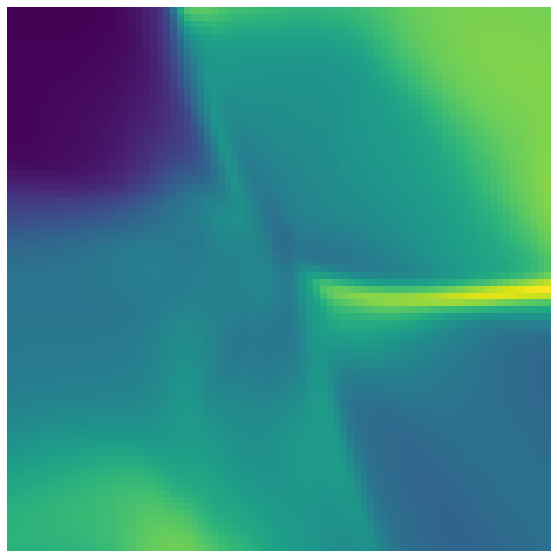

4/4 [==============================] - 0s 82ms/step - loss_dde_real: 77.3818 - loss_dde_fake: 90.7649 - gen_loss: 16476.8637
Epoch 702/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 79.0119 - loss_dde_fake: 91.4372 - gen_loss: 15371.5418
Epoch 703/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.0407 - loss_dde_fake: 92.7856 - gen_loss: 15257.9086
Epoch 704/1000
4/4 [==============================] - 0s 28ms/step - loss_dde_real: 79.4185 - loss_dde_fake: 90.3933 - gen_loss: 15549.1643
Epoch 705/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.3362 - loss_dde_fake: 92.5392 - gen_loss: 16208.0027
Epoch 706/1000
4/4 [==============================] - 0s 30ms/step - loss_dde_real: 77.9020 - loss_dde_fake: 92.1126 - gen_loss: 15328.1584
Epoch 707/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.7148 - loss_dde_fake: 94.3026 - gen_loss: 15294.1160
Epoch 708/1000
4/4 [===============

4/4 [==============================] - 0s 34ms/step - loss_dde_real: 78.3336 - loss_dde_fake: 93.3115 - gen_loss: 17641.7465
Epoch 760/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.0582 - loss_dde_fake: 94.2884 - gen_loss: 17537.3480
Epoch 761/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 76.9503 - loss_dde_fake: 91.9389 - gen_loss: 16778.2672
Epoch 762/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.0041 - loss_dde_fake: 93.7101 - gen_loss: 16696.9965
Epoch 763/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 79.3076 - loss_dde_fake: 93.1289 - gen_loss: 17309.3438
Epoch 764/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.4829 - loss_dde_fake: 93.5628 - gen_loss: 16269.3357
Epoch 765/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 79.7380 - loss_dde_fake: 90.5165 - gen_loss: 15986.2482
Epoch 766/1000
4/4 [===============

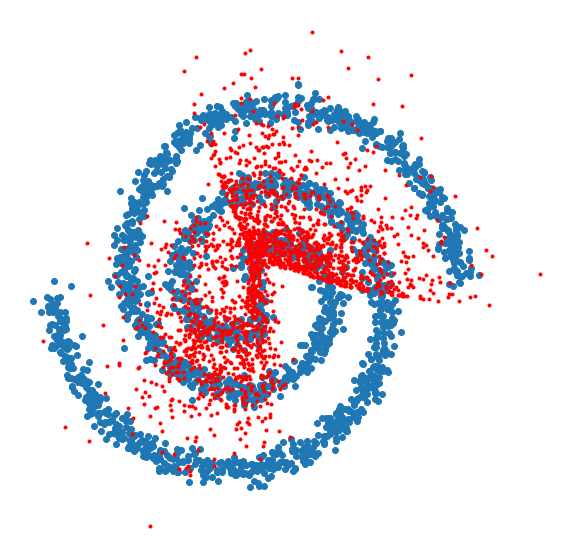

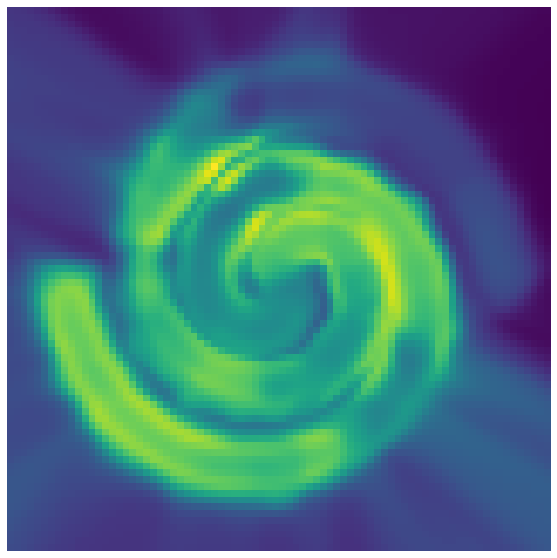

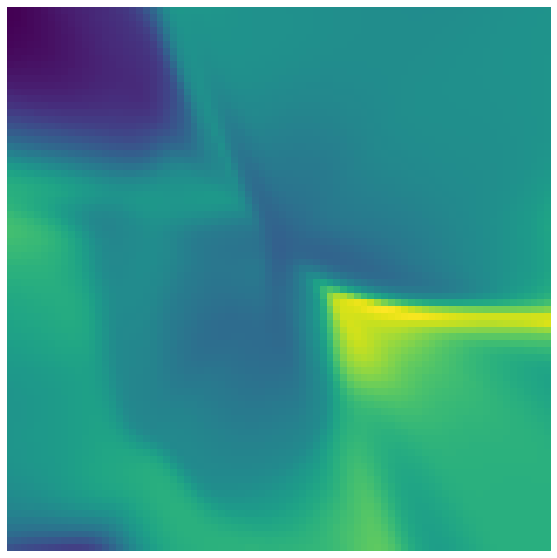

4/4 [==============================] - 0s 82ms/step - loss_dde_real: 80.5937 - loss_dde_fake: 92.8955 - gen_loss: 13233.4719
Epoch 802/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 79.7281 - loss_dde_fake: 92.5242 - gen_loss: 12942.0807
Epoch 803/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 78.1143 - loss_dde_fake: 93.1828 - gen_loss: 13275.6137
Epoch 804/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 79.0606 - loss_dde_fake: 92.9132 - gen_loss: 13268.4008
Epoch 805/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 79.2439 - loss_dde_fake: 92.3063 - gen_loss: 14027.1977
Epoch 806/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.9637 - loss_dde_fake: 93.3298 - gen_loss: 14171.9859
Epoch 807/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 76.5582 - loss_dde_fake: 91.8425 - gen_loss: 15129.8832
Epoch 808/1000
4/4 [===============

4/4 [==============================] - 0s 33ms/step - loss_dde_real: 79.9374 - loss_dde_fake: 94.5038 - gen_loss: 14867.6279
Epoch 860/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 75.7376 - loss_dde_fake: 93.5360 - gen_loss: 16060.5051
Epoch 861/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 77.3769 - loss_dde_fake: 92.7670 - gen_loss: 16639.1762
Epoch 862/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 76.3890 - loss_dde_fake: 94.7721 - gen_loss: 15728.3031
Epoch 863/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 79.3093 - loss_dde_fake: 94.2948 - gen_loss: 15129.5971
Epoch 864/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.3165 - loss_dde_fake: 93.2385 - gen_loss: 15423.6318
Epoch 865/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 78.1242 - loss_dde_fake: 92.6214 - gen_loss: 16101.4000
Epoch 866/1000
4/4 [===============

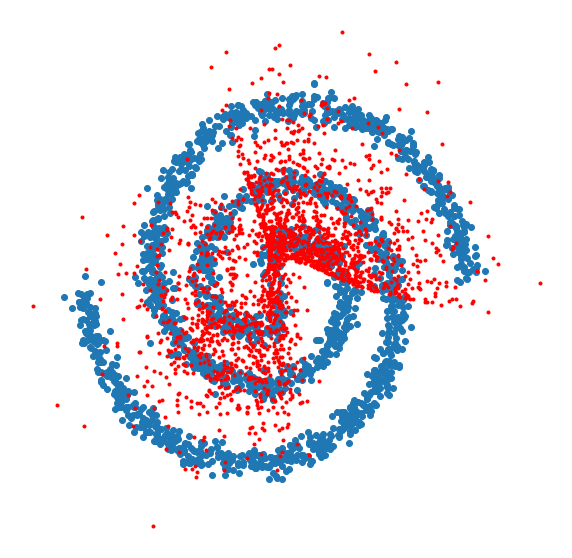

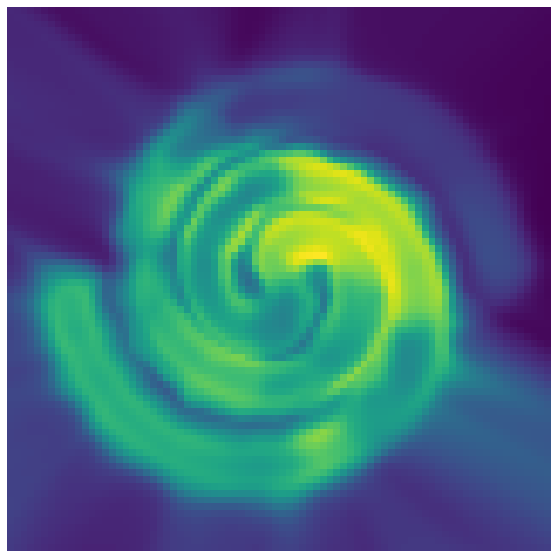

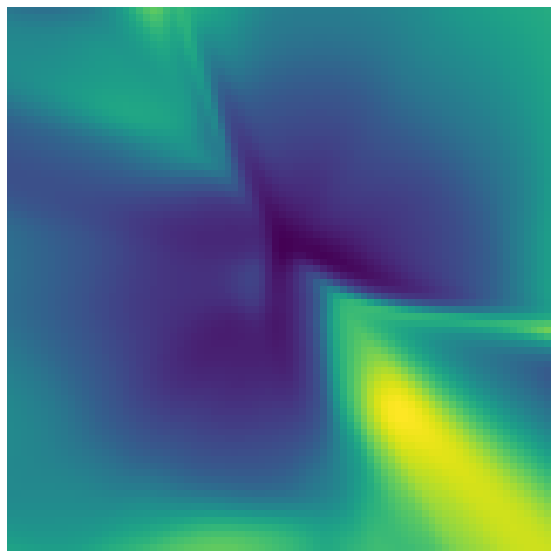

4/4 [==============================] - 0s 85ms/step - loss_dde_real: 78.1257 - loss_dde_fake: 94.8478 - gen_loss: 16814.9430
Epoch 902/1000
4/4 [==============================] - 0s 23ms/step - loss_dde_real: 79.4433 - loss_dde_fake: 93.7255 - gen_loss: 16888.6793
Epoch 903/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 77.7491 - loss_dde_fake: 94.7319 - gen_loss: 17803.3723
Epoch 904/1000
4/4 [==============================] - 0s 33ms/step - loss_dde_real: 77.4759 - loss_dde_fake: 94.4066 - gen_loss: 16870.1988
Epoch 905/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 79.0515 - loss_dde_fake: 96.3013 - gen_loss: 17827.3316
Epoch 906/1000
4/4 [==============================] - 0s 32ms/step - loss_dde_real: 76.6996 - loss_dde_fake: 95.3196 - gen_loss: 17094.3594
Epoch 907/1000
4/4 [==============================] - 0s 36ms/step - loss_dde_real: 78.5801 - loss_dde_fake: 95.0920 - gen_loss: 18210.1805
Epoch 908/1000
4/4 [===============

4/4 [==============================] - 0s 33ms/step - loss_dde_real: 78.9400 - loss_dde_fake: 95.6415 - gen_loss: 16257.2645
Epoch 959/1000
4/4 [==============================] - 0s 35ms/step - loss_dde_real: 77.0895 - loss_dde_fake: 96.5138 - gen_loss: 16964.2393
Epoch 960/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 75.1618 - loss_dde_fake: 94.9185 - gen_loss: 17558.3324
Epoch 961/1000
4/4 [==============================] - 0s 35ms/step - loss_dde_real: 79.2262 - loss_dde_fake: 94.5740 - gen_loss: 18757.3488
Epoch 962/1000
4/4 [==============================] - 0s 31ms/step - loss_dde_real: 78.5910 - loss_dde_fake: 94.0093 - gen_loss: 19428.9371
Epoch 963/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 78.4482 - loss_dde_fake: 97.5157 - gen_loss: 19193.8879
Epoch 964/1000
4/4 [==============================] - 0s 34ms/step - loss_dde_real: 78.6489 - loss_dde_fake: 92.8611 - gen_loss: 18368.7148
Epoch 965/1000
4/4 [===============

In [9]:
# train all models

egm.fit(
    x=generator,
    epochs = 1000,
    callbacks=[ImagePlotCallback(), DensityPlotCallback()])


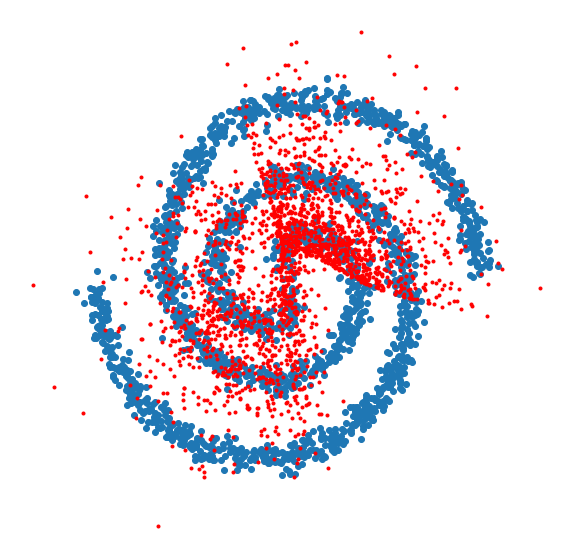

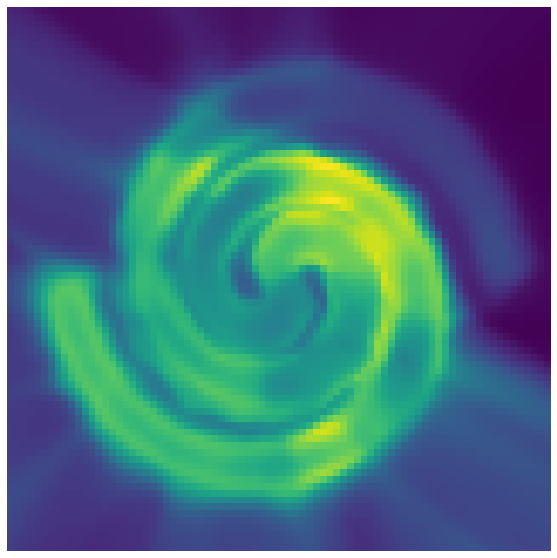

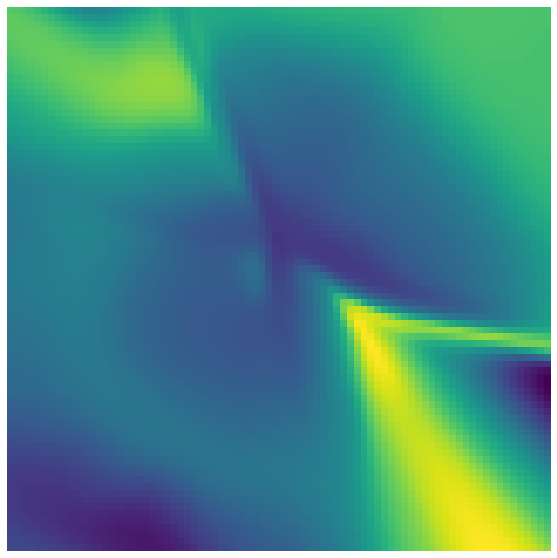

In [10]:
# Visualize resutls

ImagePlotCallback().on_epoch_end(0)
DensityPlotCallback().on_epoch_end(0)